In [ ]:
import random
import time

import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from skimage import io
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree


In [ ]:
def display_image(image):
  """This function takes an image and display it
  """
  fig = plt.figure(figsize=(10, 10))
  # plt.imshow(image)
  # REF: https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()


In [ ]:
def remove_background(image):
    """This function takes an image and removes its background
    by setting it to black pixel
    REF: https://stackoverflow.com/questions/64491530
    REF: https://www.freedomvc.com/index.php/2022/01/17/basic-background-remover-with-opencv/
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Ref: https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/

    # Apply adaptive thresholding (variation to illumination) to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area (the paper)
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour

    # Create a mask with the same shape as the input image
    mask = np.zeros_like(image)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [max_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Apply the mask to the input image
    result = cv2.bitwise_and(image, mask)

    # Get the bounding rectangle around the paper contour
    x, y, w, h = cv2.boundingRect(max_contour)

    # Crop the image based on the bounding rectangle
    paper_only = image[y:y+h, x:x+w]

    return result, paper_only


In [ ]:
def preprocess_image(image, is_input_image=True):
    if is_input_image:
      # Clean background
      clean_bg_image, _ = remove_background(image)
      image = clean_bg_image

      print("Clean background image")
      display_image(clean_bg_image)

    # Resize the image to a fixed size
    # REF: https://www.geeksforgeeks.org/image-resizing-using-opencv-python/
    desired_width = 800
    aspect_ratio = image.shape[1] / image.shape[0]
    desired_height = int(desired_width / aspect_ratio)
    resized_image = cv2.resize(image, (desired_width, desired_height))

    print("Resized image")
    display_image(resized_image)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    print("Grayscale image")
    display_image(gray_image)

    # Apply Gaussian blur to reduce noise
    # REF: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    print("Blurred image")
    display_image(blurred_image)

    return blurred_image


In [ ]:
def pca_compression(image):
    # Reshape the image into a 1D array
    image_flat = image.flatten()

    # Perform PCA
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    image_transformed = pca.fit_transform(image_flat.reshape(-1, 1))

    # Reconstruct the image
    image_reconstructed = pca.inverse_transform(image_transformed)

    # Reshape the reconstructed image
    image_reconstructed = np.reshape(image_reconstructed, image.shape).astype(np.uint8)

    return image_reconstructed


In [ ]:
def get_descriptors_and_keypoints(image):
    """ This function helps in finding the descriptors and keypoints using sift
    REF: https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python
    """

    # Create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # Detect keypoints and compute descriptors for given image
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Display keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)

    print("Image with keypoints")
    display_image(image_with_keypoints)

    return descriptors, keypoints


In [ ]:
def build_indexes(template_descriptors):
  # Build KD tree index for template descriptors
  kd_tree = KDTree(template_descriptors)

  # # Query the KD tree with input descriptors
  # distances, indices = kd_tree.query(input_descriptors, k=2)

  # return distances, indices

  return kd_tree


In [ ]:
def feature_matching(input_descriptors, template_descriptors, threshold=0.7):
    """Threshold is used to separate unreliable matches
    """
    # Calculate the pairwise distances between input and template descriptors
    distances = cdist(input_descriptors, template_descriptors, metric="euclidean")

    # Find the best matches based on the distance
    best_matches = np.argmin(distances, axis=1)

    # Filter out matches below the threshold
    good_matches = []
    for i, match_index in enumerate(best_matches):
        if distances[i, match_index] < threshold:
            good_matches.append((i, match_index))

    if not len(good_matches):
      good_matches = best_matches

    return good_matches


In [ ]:
def spatial_matching(input_descriptors, template_descriptors, kd_tree, best_matches, threshold=10):
    """Distance threshold is used for spatial matching
    """

    # Perform spatial matching
    spatial_matches = []
    for i, match_index in enumerate(best_matches):
        query_descriptor = input_descriptors[i, :]
        template_descriptor = template_descriptors[match_index, :]

        # Calculate the distance between the query descriptor and the template descriptor
        distance = np.linalg.norm(query_descriptor - template_descriptor)

        # Check if the distance is below the spatial threshold
        if distance < threshold:
            spatial_matches.append((i, match_index))

    return spatial_matches


In [ ]:
def cluster_matching(template_descriptors, spatial_matches, num_clusters=10):
    """Number of clusters is set for k-means
    REF: https://www.w3schools.com/python/python_ml_k-means.asp
    """

    # Collect the spatial match descriptors for clustering
    spatial_match_descriptors = np.array([template_descriptors[index, :] for _, index in spatial_matches])

    # Reshape the descriptors to have 2-dimensional shape (number of samples, number of features)
    spatial_match_descriptors = spatial_match_descriptors.reshape(len(spatial_match_descriptors), -1)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(spatial_match_descriptors)

    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_

    # Assign cluster labels to spatial matches
    clustered_matches = []
    for i, (input_index, template_index) in enumerate(spatial_matches):
        cluster_label = cluster_labels[i]
        clustered_matches.append((input_index, template_index, cluster_label))

    return clustered_matches


In [ ]:
def cluster_ranking(clustered_matches, num_clusters=10):
    # Calculate confidence scores (initially zero) for each cluster
    confidence_scores = np.zeros(num_clusters)

    for _, _, cluster_label in clustered_matches:
        confidence_scores[cluster_label] += 1

    # Rank the clusters based on confidence scores
    # Sort in descending order
    ranked_clusters = np.argsort(-confidence_scores)

    print("Cluster Confidence Scores:")
    for cluster, score in enumerate(confidence_scores):
        print(f"Cluster {cluster}: {score}")

    print("\nCluster Rankings (from highest to lowest):")
    for rank, cluster in enumerate(ranked_clusters):
        print(f"Rank {rank+1}: Cluster {cluster}")

    return ranked_clusters


Template image


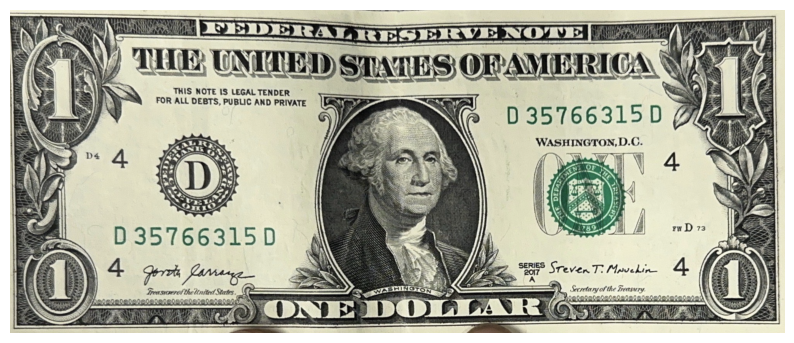

In [ ]:
# Load the template image

template_image = cv2.imread("template_image.jpg")
print("Template image")
display_image(template_image)


Preprocessing template image
Resized image


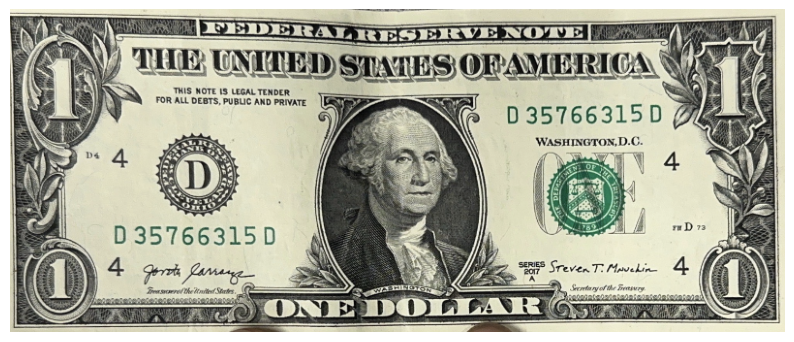

Grayscale image


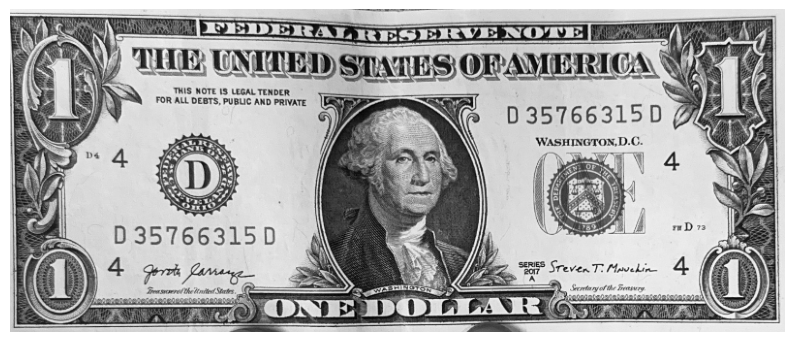

Blurred image


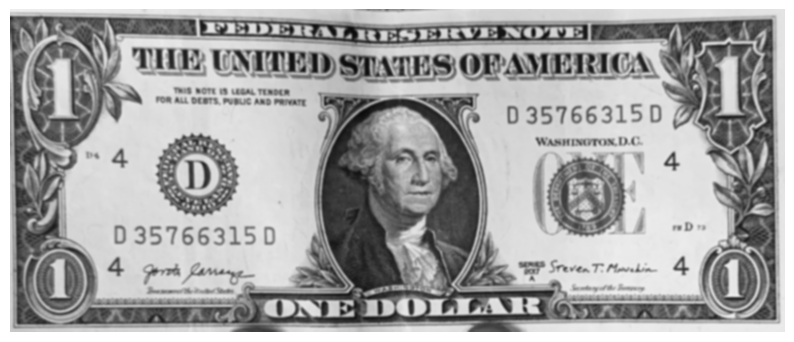

In [ ]:
# Preprocess the template image

print("Preprocessing template image")
template_image = preprocess_image(template_image, is_input_image=False)


Reconstructed template image


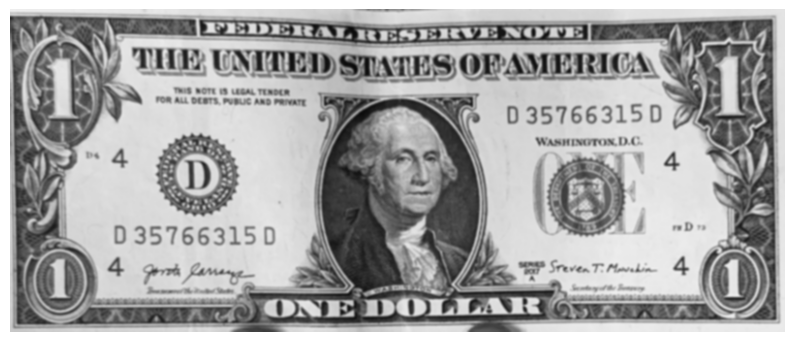

In [ ]:
# Perform PCA compression on the template image

template_image = pca_compression(template_image)
print("Reconstructed template image")
display_image(template_image)


Finding descriptors and keypoints for the template image
Image with keypoints


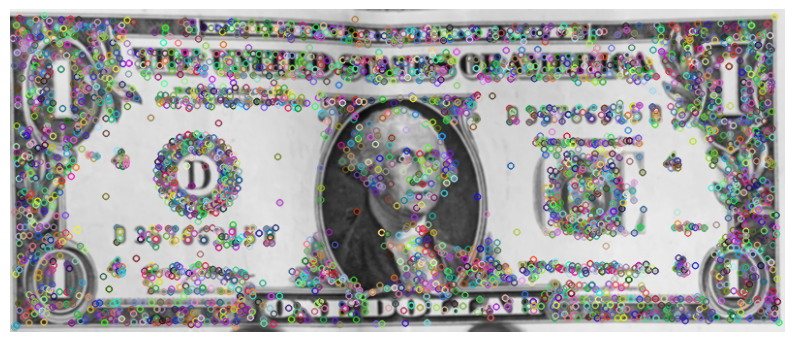

In [ ]:
# Find the descriptors for the template image

print("Finding descriptors and keypoints for the template image")
template_descriptors, template_keypoints = get_descriptors_and_keypoints(
    template_image,
)


In [ ]:
# Build indexes using template image descriptors

kd_tree = build_indexes(template_descriptors)


In [ ]:
# Perform index/feature pruning

Input image


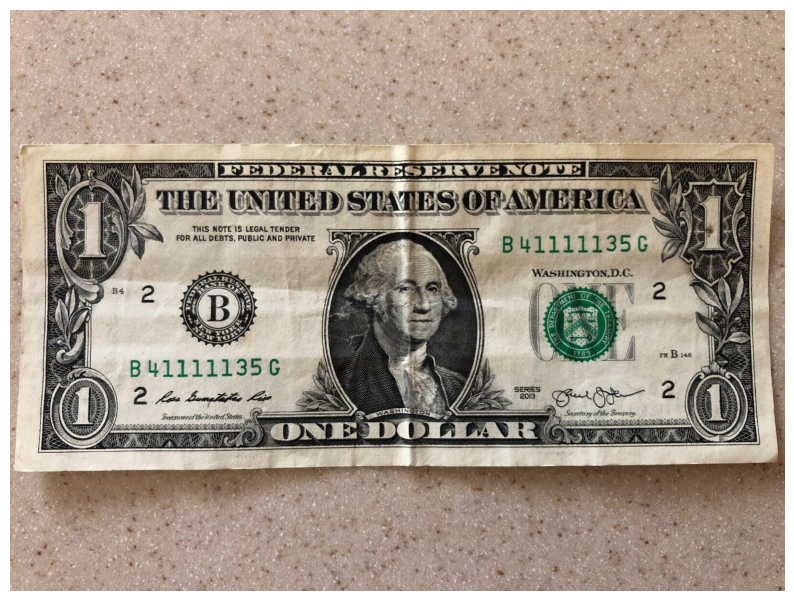

In [ ]:
# Load the input image

input_image = cv2.imread("input_image_1.jpg")
print("Input image")
display_image(input_image)


In [ ]:
# Get the start time
start_time = time.time()


Preprocessing input image
Clean background image


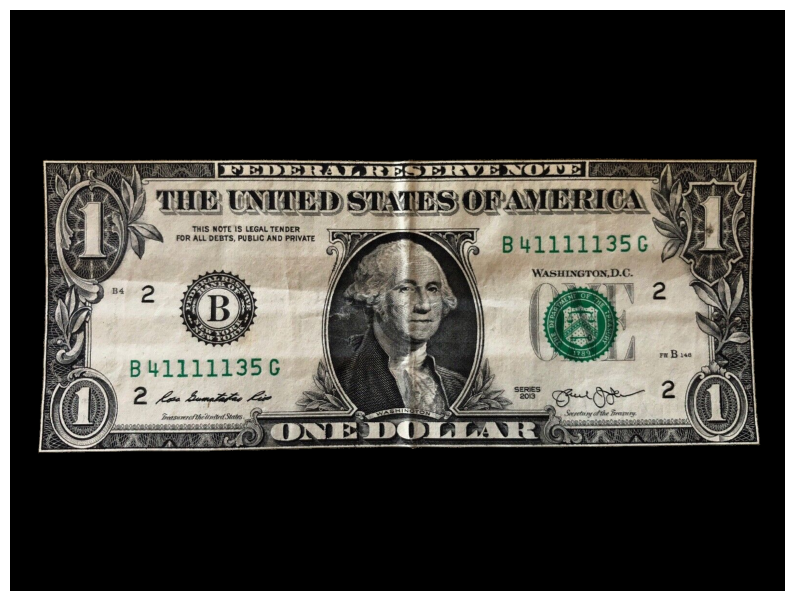

Resized image


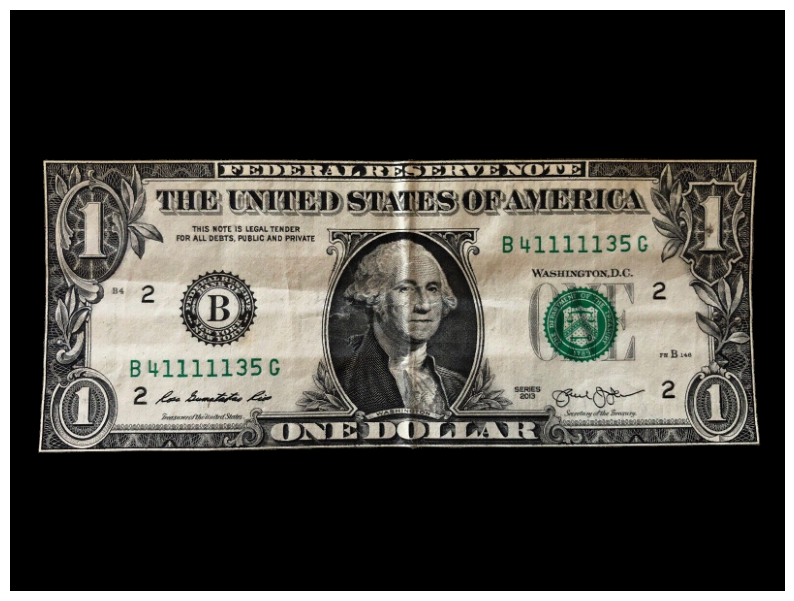

Grayscale image


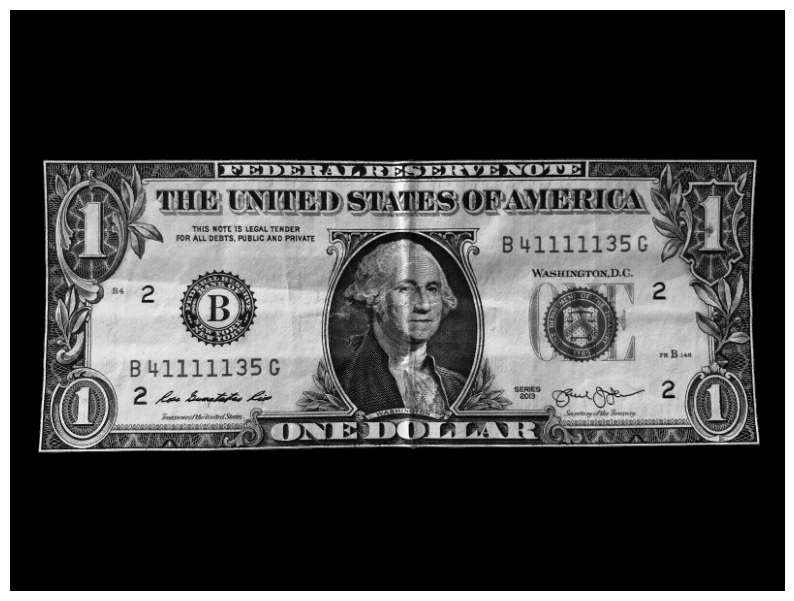

Blurred image


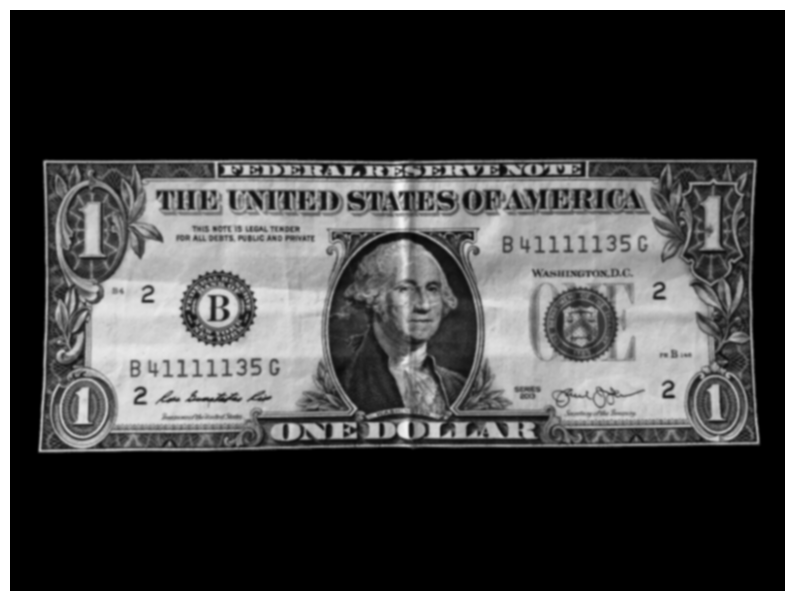

Preprocessing time taken:  2.0388336181640625 seconds


In [ ]:
# Preprocess the input image

# Get the preprocessing start time
preprocessing_start_time = time.time()

print("Preprocessing input image")
input_image = preprocess_image(input_image, is_input_image=True)

# Get the preprocessing end time
preprocessing_end_time = time.time()

# Get the preprocessing elapsed time
preprocessing_elapsed_time = preprocessing_end_time - preprocessing_start_time
print("Preprocessing time taken: ", preprocessing_elapsed_time, "seconds")


Reconstructed input image


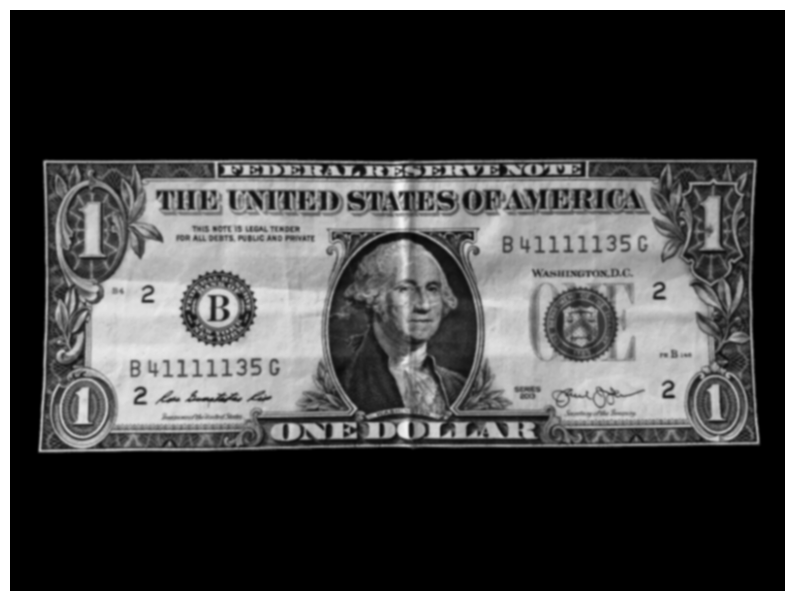

In [ ]:
# Perform PCA compression

input_image = pca_compression(input_image)
print("Reconstructed input image")
display_image(input_image)


Finding descriptors and keypoints for the input image
Image with keypoints


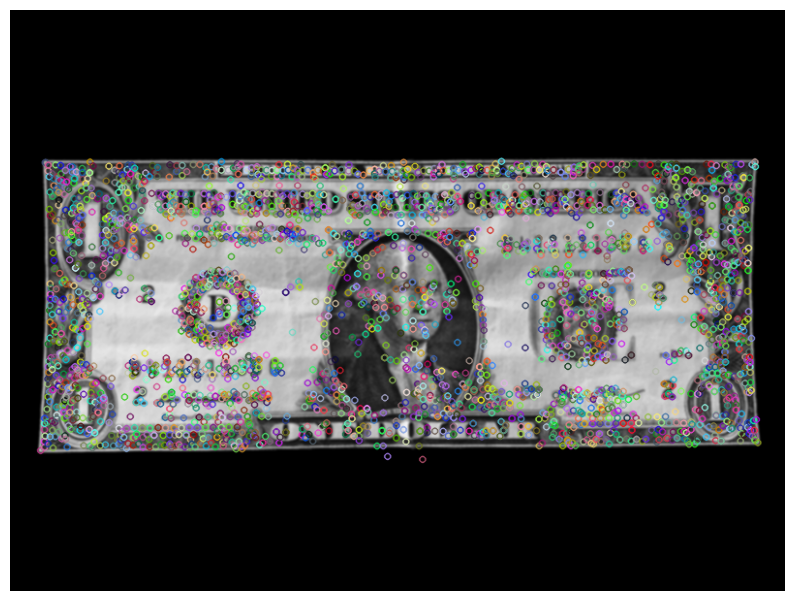

In [ ]:
# Find the descriptors and keypoints for the input image

print("Finding descriptors and keypoints for the input image")
input_descriptors, input_keypoints = get_descriptors_and_keypoints(
    input_image,
)


In [ ]:
# Perform feature matching of input descriptors from template descriptors

best_matches = feature_matching(input_descriptors, template_descriptors, threshold=0.7)
print("Feature matches:", len(best_matches))


Feature matches: 3211


In [ ]:
# Perform spatial matching

spatial_matches = spatial_matching(
    input_descriptors,
    template_descriptors,
    kd_tree,
    best_matches,
    threshold=200,
)
print("Spatial matches:", len(spatial_matches))


Spatial matches: 1231


In [ ]:
# Perform cluster matching

clustered_matches = cluster_matching(template_descriptors, spatial_matches, num_clusters=10)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Perform cluster ranking

ranked_clusters = cluster_ranking(clustered_matches, num_clusters=10)


Cluster Confidence Scores:
Cluster 0: 109.0
Cluster 1: 138.0
Cluster 2: 114.0
Cluster 3: 118.0
Cluster 4: 79.0
Cluster 5: 170.0
Cluster 6: 52.0
Cluster 7: 136.0
Cluster 8: 102.0
Cluster 9: 213.0

Cluster Rankings (from highest to lowest):
Rank 1: Cluster 9
Rank 2: Cluster 5
Rank 3: Cluster 1
Rank 4: Cluster 7
Rank 5: Cluster 3
Rank 6: Cluster 2
Rank 7: Cluster 0
Rank 8: Cluster 8
Rank 9: Cluster 4
Rank 10: Cluster 6


In [ ]:
# Get the end time
end_time = time.time()
# Get the execution time
elapsed_time = end_time - start_time
print("Execution time:", elapsed_time, "seconds")


Execution time: 6.075999975204468 seconds


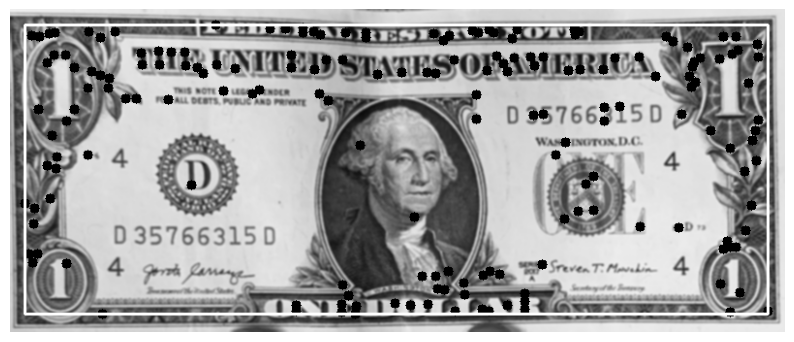

In [ ]:
# Find the best-ranked cluster
best_cluster = ranked_clusters[0]

# Extract the corresponding matches for the best-ranked cluster
best_cluster_matches = [(input_index, template_index) for input_index, template_index, cluster_label in clustered_matches if cluster_label == best_cluster]

# Extract the region of the template image corresponding to the best-ranked cluster
template_region = template_image.copy()
for input_index, template_index in best_cluster_matches:
    x, y = template_keypoints[template_index].pt
    cv2.circle(template_region, (int(x), int(y)), 5, (0, 255, 0), -1)

# Get the bounding box coordinates for the region
x_min = int(min(template_keypoints[template_index].pt[0] for _, template_index in best_cluster_matches))
y_min = int(min(template_keypoints[template_index].pt[1] for _, template_index in best_cluster_matches))
x_max = int(max(template_keypoints[template_index].pt[0] for _, template_index in best_cluster_matches))
y_max = int(max(template_keypoints[template_index].pt[1] for _, template_index in best_cluster_matches))

# Draw the outline of the region on the template image
cv2.rectangle(template_region, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

display_image(template_region)


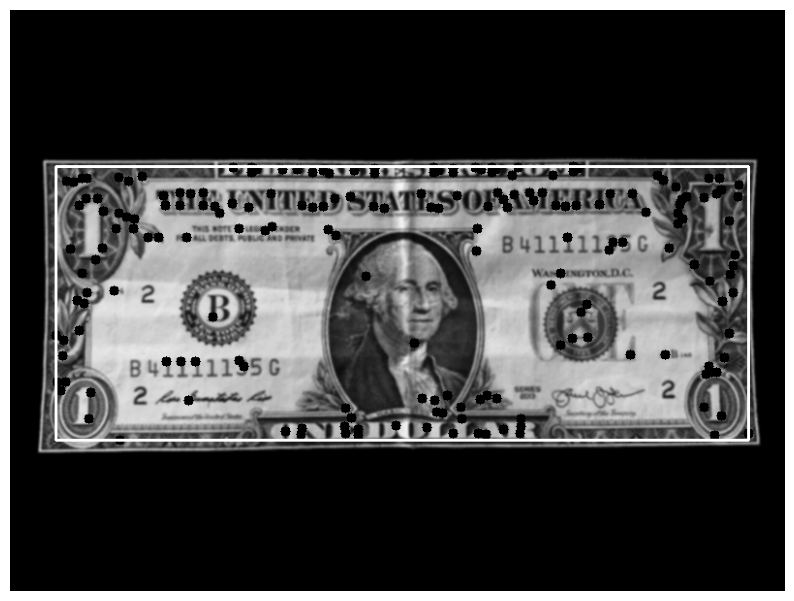

In [ ]:
# Find the best-ranked cluster
best_cluster = ranked_clusters[0]

# Extract the corresponding matches for the best-ranked cluster
best_cluster_matches = [(input_index, template_index) for input_index, template_index, cluster_label in clustered_matches if cluster_label == best_cluster]

# Extract the region of the input image corresponding to the best-ranked cluster
input_region = input_image.copy()
for input_index, _ in best_cluster_matches:
    x, y = input_keypoints[input_index].pt
    cv2.circle(input_region, (int(x), int(y)), 5, (0, 255, 0), -1)

# Get the bounding box coordinates for the region
x_min = int(min(input_keypoints[input_index].pt[0] for input_index, _ in best_cluster_matches))
y_min = int(min(input_keypoints[input_index].pt[1] for input_index, _ in best_cluster_matches))
x_max = int(max(input_keypoints[input_index].pt[0] for input_index, _ in best_cluster_matches))
y_max = int(max(input_keypoints[input_index].pt[1] for input_index, _ in best_cluster_matches))

# Draw the outline of the region on the input image
cv2.rectangle(input_region, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

display_image(input_region)


In [ ]:
# Calculate the size of the template image
template_height, template_width = template_image.shape
template_size = template_height * template_width

# Calculate the size of the best-cluster region
region_size = (x_max - x_min) * (y_max - y_min)

# Calculate the percentage of the image match
match_percentage = (region_size / template_size) * 100

# Print the match percentage
print(f"Template Image Match Percentage: {match_percentage:.2f}%")


Template Image Match Percentage: 75.69%


In [ ]:
# Calculate the size of the input image
input_height, input_width = input_image.shape
input_size = input_height * input_width

# Calculate the size of the best-cluster region
region_size = (x_max - x_min) * (y_max - y_min)

# Calculate the percentage of the image match
match_percentage = (region_size / input_size) * 100

# Print the match percentage
print(f"Input Image Match Percentage: {match_percentage:.2f}%")

Input Image Match Percentage: 42.01%
